**классификатор SVM** 

Евгений Борисов  <esborisov@sevsu.ru>

---

http://www.ccas.ru/voron/download/SVM.pdf

http://www.machinelearning.ru/wiki/images/archive/a/a0/20150316112120%21Voron-ML-Lin-SVM.pdf

https://habr.com/ru/company/ods/blog/484148/

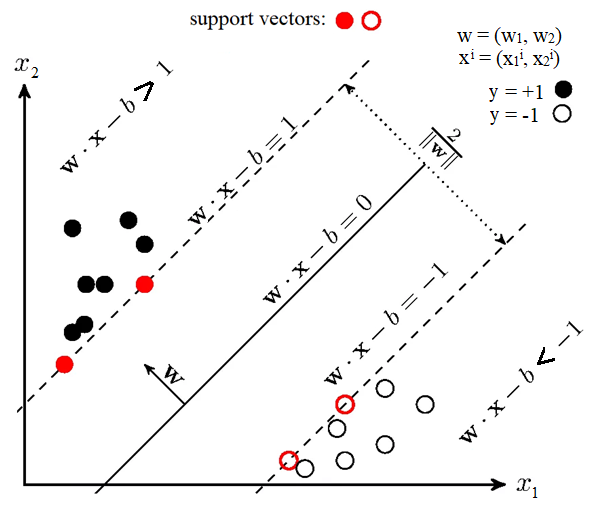

модель - линейный классификатор

$$a(x) = sign( w^T\cdot x - b )$$

метки классов 
$$y \in \{-1,+1\}$$

margine (отступ)

$$ M = y\cdot ( w^T x - b )$$

$\langle x,w\rangle - b = 0 $ - разделяющая гиперплоскость


$\langle x_+,w\rangle - b > 1$ - для позитивно размеченных объектов


$\langle x_-,w\rangle - b < -1$ - для негативно размеченных объектов

**ширина разделяющей полосы**

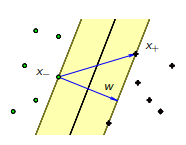

выберем пару разноразмеченных опорных точек

для определённости положим отступ $M(x_{s})=1$ для опорных точек  

тогда

$\langle x_+,w\rangle - b = 1$ - для опорных позитивно размеченных 


$\langle x_-,w\rangle - b = -1$ - для опорных негативно размеченных





$\langle x_+,w\rangle = b + 1$     
$\langle x_-,w\rangle = b - 1$

тогда ширину полосы можно получить как проекцию(???) $x_+  - x_-$

$$  
\left\langle x_+ - x_- ,\frac{w}{\|w\|}\right\rangle 
=\frac{\langle x_+,w\rangle  - \langle x_-,w\rangle}{\|w\|} 
=\frac{ (b+1)  - (b-1)}{\|w\|} 
=\frac{2}{\|w\|} 
$$

---

**условие 1.** максимизация ширины разделяющей полосы

$$2/ \|w\| \rightarrow max $$ 

$$\|w\| \rightarrow min$$

$$w^T\cdot w \rightarrow min$$

**условие 2.** никакому объекту не разрешается попадать на полосу разделения (hard-margin SVM)

если $ M<0 $ то ошибка классификации 

$$ y\cdot ( w^T x - b )\geq 1$$

**hard-margin SVM** (SVM с жестким зазором), никакому объекту не разрешается попадать на полосу разделения

объединяем два, выше описанных, условия 

$$
\begin{cases}
w^T\cdot w \rightarrow min\\
y\cdot ( w^T x - b )\geq 1
\end{cases}
$$


Решается аналитически через теорему Куна-Таккера.   
Получаемая задача эквивалентна двойственной задаче поиска седловой точки функции Лагранжа.

---

hinge loss

$$H = max(0,1-y(w^Tx))$$

Почему именно Hinge_loss максимизирует зазор? – для начала вспомним, что гиперплоскость меняет свое положение тогда, когда изменяются веса $w$ и $b$. Веса алгоритма начинают меняться, когда градиенты лосс-функции не равны нулю (обычно говорят: “градиенты текут”). Поэтому мы специально подобрали такую лосс-функцию, у которой начинают течь градиенты в нужное время. $Hinge loss$ выглядит следующим образом: $H = max(0,1-y(w^Tx))$. Помним, что зазор $m=y(w^Tx)$. Когда зазор $m$ достаточно большой ($1$ или более), выражение $(1-m)$ становится меньше нуля и $H=0$ (поэтому градиенты не текут и веса алгоритма никак не изменяются). Если же зазор m достаточно мал (например, когда объект попадает на полосу разделения и/или отрицательный (при неверном прогнозе классификации), то Hinge_loss становится положительной ($H>0$), начинают течь градиенты и веса алгоритма изменяются. Резюмируя: градиенты текут в двух случаях: когда объект выборки попал внутрь полосы разделения и при неправильной классификации объекта.

---

чтобы алгоритм смог работать и с линейно неразделимых данными,   
позволим ему допускать ошибки на обучающих объектах,    
введём набор дополнительных переменных $\xi _i \geq 0$,    
характеризующих величину ошибки на каждом объекте $x_i$.  
введём в минимизируемый функционал штраф за суммарную ошибку  

$$
\begin{cases}
w^T\cdot w + \alpha \sum \xi_i \rightarrow min\\
y\cdot ( w^T x_i - b )\geq 1 - \xi_i\\
\xi_i \geq 0
\end{cases}
$$


$$Penalty = \sum[M_i < 0] \leqslant \sum(1- M_i)_+ = \sum max(0,1-M_i)$$

**soft-margin SVM** (SVM с мягким зазором)

$$Q = max(0,1- M_i) + \alpha(w^T\cdot w)/2 = max(0, 1- y \cdot w^T\cdot x) + \alpha(w^T\cdot w)/2$$

$Q$ — функция потерь, будем её минимизировать с помощью градиентного спуска

$$w = w - \eta\bigtriangledown Q$$

$$ 
\bigtriangledown Q = \left\{ 
\begin{array}{ll} 
\alpha w-yx & , & yw^Tx<1\\ 
\alpha w & , & yw^Tx\geqslant 1 
\end{array} 
\right. 
$$


In [1]:
import numpy as np
from numpy import random as rng
import matplotlib.pyplot as plt

In [2]:
np.set_printoptions(precision=2)

## генерируем данные

In [3]:
n_samples = 500

# from sklearn.datasets import make_blobs
# X,target = make_blobs( n_samples=n_samples, centers=2,  cluster_std=[1.5, 1.8,] )

from sklearn.datasets import make_moons
X,target = make_moons(n_samples=n_samples, noise=.09)

y = (target*2-1)[:,np.newaxis]

X.shape, y.shape

((500, 2), (500, 1))

In [4]:
# y

In [5]:
# нормируем данные
# from sklearn.preprocessing import MinMaxScaler
# X = MinMaxScaler([-1.0,1.0]).fit_transform(X)

# from sklearn.preprocessing   import StandardScaler
# X = StandardScaler().fit(X).transform(X)

In [6]:
# np.percentile(X,[10,25,50,75,95],axis=0) 

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.5)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((250, 2), (250, 1), (250, 2), (250, 1))

In [8]:
del X
del y
del target

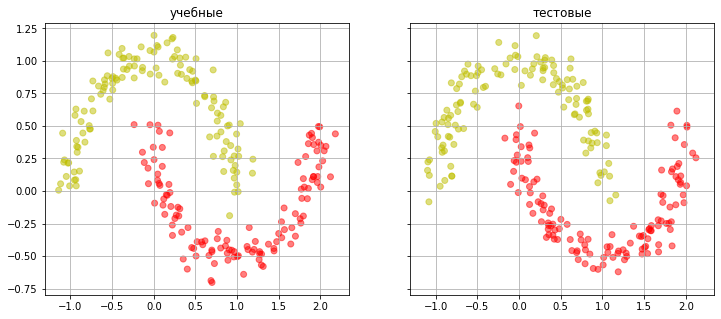

In [9]:
def plot_data(ax,X,y,t):
    c = [ ['b','r','g','y'][j] for j in y.flatten()  ]
    ax.set_title(t)
    ax.scatter( x=X[:,0], y=X[:,1], c=c,  alpha=0.5 )
    ax.grid()

fig, (ax0,ax1) = plt.subplots(1,2, sharey=True, sharex=True, figsize=(12,5),)
plot_data(ax0,X_train,y_train,'учебные')    
plot_data(ax1,X_test,y_test,'тестовые')    
plt.show()

In [10]:
# полиномиальное ядро степени poly_degree

from sklearn.preprocessing import PolynomialFeatures

poly_degree = 3 # степень полинома

# собираем полином, добавляем столбец из единиц (свободный член w0)
kernel = PolynomialFeatures(poly_degree).fit(X_train)
Xp = kernel.transform(X_train)
Xp.shape

(250, 10)

## модель

$$a(x,w) = sign\left( \sum\limits_{i=1} x_i \cdot w_i + w_0\right)$$

In [11]:
def score(x,w):
    return x.dot(w)[:,np.newaxis]

def predict(x,w):
    return np.sign(score(x,w)).astype(int)

## обучаем модель

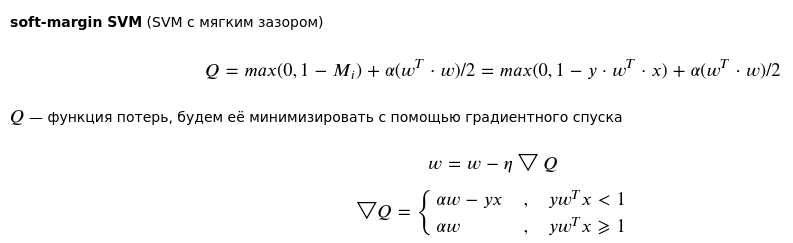

In [12]:
# n_param = Xp.shape[1] 
# w = rng.normal(size=(n_param))
# w

In [13]:
# w.dot(w.T)

In [14]:
def hinge(x,w,y,a=1e-1): # функция потери
    margin = y*score(x,w)
    w_norm = w.dot(w.T)
    return ( np.where(margin<1.,(1.-margin),0.) + a*w_norm ).sum()/len(y)

loss = hinge

In [15]:
# hinge(Xp,w,y_train,a=1e-1)

In [16]:
def hinge_partial(x,w,y,a=1e-7): # градиент функции потери
    margin = y*score(x,w)
    g = np.where(margin<1., a*w-y*x ,a*w).sum(axis=0)/len(y)
    g /= np.abs(g).max() # нормируем градиент
    return g.flatten()

gradient = hinge_partial

---

In [17]:
def weight_adjust(w,g,lr):
    return w - lr*g # корректируем параметры

In [18]:
def fit_epoch(x,y,w,lr,a): # шаг обучения модели
    g = gradient(x,w,y,a) # градиент функции потери, изменение весов
    return weight_adjust(w,g,lr) # корректируем параметры

In [19]:
from sklearn.metrics import accuracy_score

In [20]:
%%time

# метод градиентного спуска

lr = 1e-2 # скорость обучени
n_samples = len(y_train) # количество примеров
n_epoch = 1000 # максимальное число циклов обучения
acc_min = .98 # порог минимально допустимой погрешности модели
n_param = Xp.shape[1] # размер вектора признаков
a = 1e-2 # коэффициент допустимой ошибки soft hinge loss

# инициализация параметров модели
w = rng.normal(size=(n_param))
#w = np.array( [0] + [1]*(n_param-1) )

# начальное значение ф-ции потери
loss_history = [ loss(Xp,w,y_train,a) ]
acc_history = [ accuracy_score( y_train , predict(Xp,w) ) ]

for i in range(n_epoch): # цикл обучения
    w = fit_epoch(Xp,y_train,w,lr,a) # корректируем веса модели
    loss_history.append( loss(Xp,w,y_train,a) ) # считаем значение ф-ции потери
    acc_history.append( accuracy_score( y_train, predict(Xp,w) ) )
    
    if acc_history[-1] > acc_min: # проверяем достижение минимального порога погрешности модели
        print('step %i/%i: loss %.03f, acc threshold %.03f reached\n'%(i+1,n_epoch,loss_history[-1],acc_min))
        break

step 544/1000: loss 0.190, acc threshold 0.980 reached

CPU times: user 151 ms, sys: 939 µs, total: 152 ms
Wall time: 154 ms


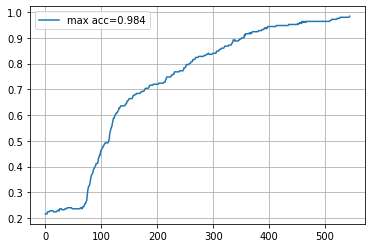

In [21]:
# история изменения значений погрешности модели
plt.plot(acc_history,label='max acc=%.3f'%(max(acc_history)))
plt.grid()
plt.legend()

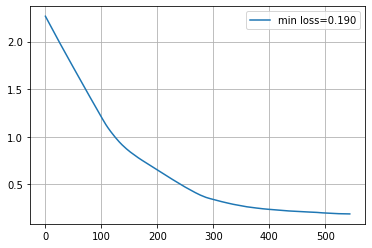

In [22]:
# история изменения значений ф-ции потери
plt.plot(loss_history,label='min loss=%.3f'%(min(loss_history)))
plt.grid()
plt.legend()

## тестируем модель

In [23]:
s = score(kernel.transform(X_test),w)

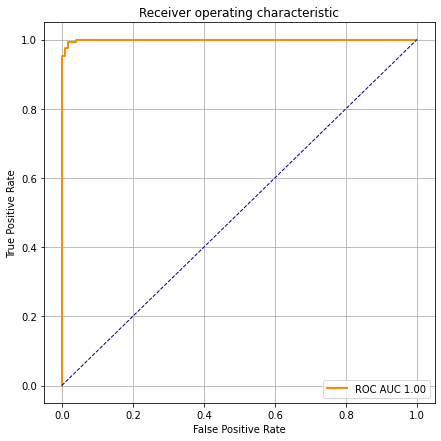

In [24]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

fpr, tpr, thresholds = roc_curve( y_test, s )
roc_auc = auc(fpr,tpr)

plt.figure(figsize=(7,7))
plt.grid(True)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC AUC %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [25]:
# оптимальный порого скора 
#  максимальное количество True Positive при минимальном количестве False Positive
optimal_threshold = thresholds[ np.argmax( np.abs(tpr-fpr) )  ]
optimal_threshold

-0.07439000335861573

In [26]:
p = (s>optimal_threshold).astype(int)
y = (y_test>0).astype(int)

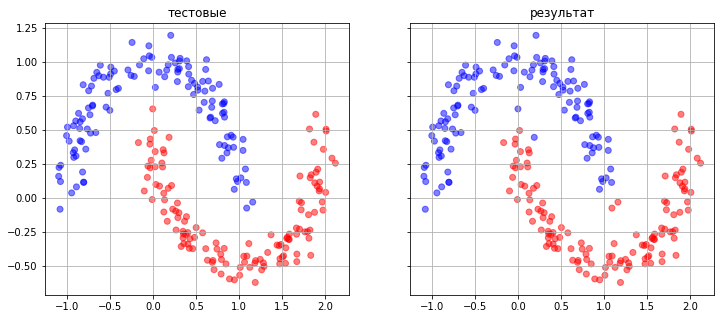

In [27]:
fig, (ax0,ax1) = plt.subplots(1,2, sharey=True, sharex=True, figsize=(12,5),)
plot_data(ax0,X_test,y,'тестовые')    
plot_data(ax1,X_test,p,'результат')    
plt.show()

In [28]:
from sklearn.metrics import classification_report
print(classification_report(y,p))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       122
           1       0.98      0.98      0.98       128

    accuracy                           0.98       250
   macro avg       0.98      0.98      0.98       250
weighted avg       0.98      0.98      0.98       250



## карта скоров

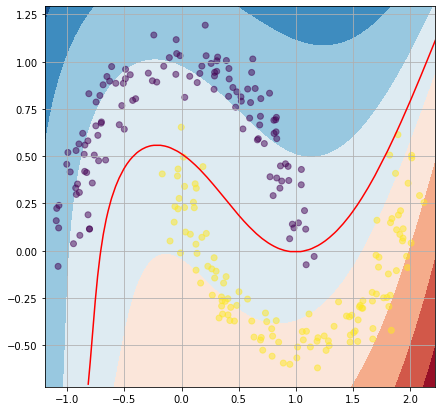

In [82]:
# строим сетку и определяем значения скора классификатора во всех узлах

n=1000 # количество разбиений сетки

xx,yy = np.meshgrid(
    np.linspace( X_test[:,0].min()-.1, X_test[:,0].max()+.1, n), 
    np.linspace( X_test[:,1].min()-.1, X_test[:,1].max()+.1, n)
) # узлы сетки

xy = np.vstack([xx.flatten(),yy.flatten() ]).T # разворачиваем сетку 

s = score(kernel.transform(xy),w)

plt.figure(figsize=(7,7))
plt.contourf(xx, yy, (1.-s).reshape(n,n), cmap=plt.cm.RdBu)
plt.scatter( x=X_test[:,0], y=X_test[:,1], c=y_test, alpha=.5 )

# v = np.hstack([xy,s])
# m = v[ np.abs(v[:,-1])<5e-4,: ]
# m = m[np.argsort(m[:,0]),:]
# plt.plot(m[:,0],m[:,1],c='r')

plt.grid()